<a href="https://colab.research.google.com/github/sblakebridges/sbbridges-public/blob/main/nfl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to Score More Points in NFL Games?**

# **1. Define the problem**
For our research project, we chose to investigate the factors that contribute to passing plays in the National Football League (NFL) resulting in positive expected points added (EPA), to identify which factors ultimately impact EPA the most. Expected points (EP) is a metric used in the NFL that represents the number of points a team is expected to score on the current drive. The expected points added metric measures how a team’s expected points value changes on an individual play. Each play in an NFL game has many different moving parts, such as offensive and defensive formation, personnel, down, and distance to the first down marker. We were interested in developing a method to determine which factors on the football field are most important to determining a successful passing play, using EPA as our measure of success.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# **2. Data collection**
We worked with a dataset from the popular data analytics website Kaggle. The author of the dataset is Arya Shah. In particular, we used the file named ‘plays.csv’, which contained information on individual plays during the 2018-19 NFL regular season. This play-by-play data was likely collected by statisticians and analysts from various NFL organizations during actual games, and then made publicly available through league databases or popular sports analytics websites. This dataset initially contained 19,239 samples and 27 different features. Again, in this case, each sample represents an individual play run by an NFL team during the 2018-19 regular season. Some of the seemingly most relevant features in the original dataset were the current down on the play ran, the number of yards needed for a first down, the absolute yard line number, the result of the pass thrown (completion, incompletion, interception), and both the offensive and defensive personnel. Some features such as the description of the play were difficult to quantify, and others, like ones regarding identification of the specific game and play, were irrelevant to predicting EPA on any given play. One of the major limitations of the dataset is that it solely contains information on passing plays! We cannot draw any conclusions regarding rushing or special teams plays and how they relate to EPA.


In [ ]:
plays = pd.read_csv('plays.csv')

print(plays.shape)
plays.head()

(19239, 27)


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


# **3. Data preparation**
We removed data regarding penalties because that isn’t something an offense can always control. While technically an offense can cause a defense to commit a penalty, that isn’t always the case, and much of the time it’s purely because of a mistake of a defender, so we decided that it was better to drop all plays that resulted in penalties. We did this by only including the rows where there was a null value in penaltyCodes.



In [ ]:
# remove plays where penalties occur, remove features related to penalties
no_penalties = (plays['penaltyCodes'].isnull())

plays = plays[no_penalties].drop(columns=['penaltyCodes',
                                  'penaltyJerseyNumbers',
                                  'isDefensivePI'])

plays.shape

(18033, 24)

We did additional data preparation by dropping columns that had no impact on predicting EPA, such as gameId and playId.

In [ ]:
plays = plays.drop(columns=['gameId',         # these are identifying features that play no role in predicting epa
                            'playId',
                            'possessionTeam', # team is an irrelevant factor
                            'playType',       # we are looking solely at passing plays
                            'yardlineSide',   # we will use the absoluteYardlineNumber
                            'yardlineNumber',
                            'playResult',     # this variable is the same as offensePlayResult since we excluded penalties
                            'playDescription']) # hard to interpret long string values

plays.shape

(18033, 16)

Rather than try to fill in missing values, we decided to drop any play that had a missing value for one or more features. This reduces the number of samples we have to work with, but there are still a significant amount leftover.

In [ ]:
plays = plays.dropna(how='any')
plays.shape

(17935, 16)

We converted a few categorical variables to numerical variables. We expanded offenseFormation and typeDropback into binary columns of all possible values in the dataset using the pandas function get_dummies().

In [ ]:
# split offensive formation and dropback type into useable cols
plays = pd.get_dummies(plays, columns=['typeDropback', 'offenseFormation'], dtype=int, drop_first=False)

We used the same technique to deal with the down and quarter categorical variables.

In [ ]:
# encode down and quarter categorical variables into true-false columns
plays = pd.get_dummies(plays, columns=['down', 'quarter'], dtype=int, drop_first=False)

Another categorical variable we changed to numeric was passResult, where we changed the types of results of a pass (incompletion, completion, sack, and interception) into 0, 1, 2, and 3 to make it a usable variable.

In [ ]:
plays['passResult'] = plays.passResult.replace({'I': 0, 'C': 1, 'S': 2, 'IN': 3}) # coding categorical passResult variable

<ipython-input-22-f1eba436ce6a>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays['passResult'] = plays.passResult.replace({'I': 0, 'C': 1, 'S': 2, 'IN': 3}) # coding categorical passResult variable


We also changed personnelO and personnelD into variables with the number of RBs, WRs, and TEs for offense and DBs, LBs, and DLs for defense. We did this with a custom function that we wrote called read_personnel(). This function splits the string of personnel into the given positions, takes the number listed before the position, and uses that as the value.

In [ ]:
# Function to read offensive and defensive personnel from plays dataframe
def read_personnel(personnel, positions):
  result = {pos: 0 for pos in positions}
  for item in personnel.split(','):
    parts = item.strip().split()
    if len(parts) == 2:
        count, position = parts
        if position in positions:
            result[position] = int(count)
  return result

# Define common positions of interest
offensive_positions = ['RB', 'TE', 'WR']
defensive_positions = ['DL', 'LB', 'DB']

# Apply function to extract positions
df_offense = plays['personnelO'].apply(lambda x: read_personnel(x, offensive_positions))
df_defense = plays['personnelD'].apply(lambda x: read_personnel(x, defensive_positions))

df_offense = pd.DataFrame(df_offense.tolist(), index=plays.index)
df_defense = pd.DataFrame(df_defense.tolist(), index=plays.index)

# New columns with proper numeric values are added to plays dataframe
plays = pd.concat([plays, df_offense.add_prefix('O_'), df_defense.add_prefix('D_')], axis=1)

In [ ]:
plays = plays.drop(columns=['personnelO',
                            'personnelD',
                            'typeDropback_UNKNOWN']) # drop unknown dropback type

We made these changes because we thought these would be valuable variables to take into account in our model, as different formations, personnel, and types of pass dropbacks have different sets of plays called with them so we wanted to see their effect on our model.


This function, named to_seconds(), takes the gameClock variable and converts the string value into strictly seconds remaining in a quarter to make it easier to work with.

In [ ]:
def to_seconds(clock): # convert gameClock strings to seconds remaining in quarter
  if pd.isna(clock):
    return None
  minutes, seconds, ms = map(int, clock.split(':'))
  return minutes * 60 + seconds

plays['secondsRemaining'] = plays['gameClock'].apply(to_seconds) # create new columns called secondsRemaining
plays = plays.drop(columns=['gameClock']) # drop gameClock column

After data preparation, there are X different features in the dataset, and our target variable of EPA.

In [ ]:
num_features = plays.shape[1] - 1
print(f"{num_features} Total Features:")
plays.info()

37 Total Features:
<class 'pandas.core.frame.DataFrame'>
Index: 17935 entries, 0 to 18605
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   yardsToGo                            17935 non-null  int64  
 1   defendersInTheBox                    17935 non-null  float64
 2   numberOfPassRushers                  17935 non-null  float64
 3   preSnapVisitorScore                  17935 non-null  float64
 4   preSnapHomeScore                     17935 non-null  float64
 5   absoluteYardlineNumber               17935 non-null  float64
 6   passResult                           17935 non-null  int64  
 7   offensePlayResult                    17935 non-null  int64  
 8   epa                                  17935 non-null  float64
 9   typeDropback_DESIGNED_ROLLOUT_LEFT   17935 non-null  int64  
 10  typeDropback_DESIGNED_ROLLOUT_RIGHT  17935 non-null  int64  
 11  typeDropback_S

# **4. Data exploration**

Before building our model, we wanted to do a little data exploration to understand how EPA might relate to other variables and how EPA is distributed in our dataset.

<Axes: xlabel='yardsToGo', ylabel='epa'>

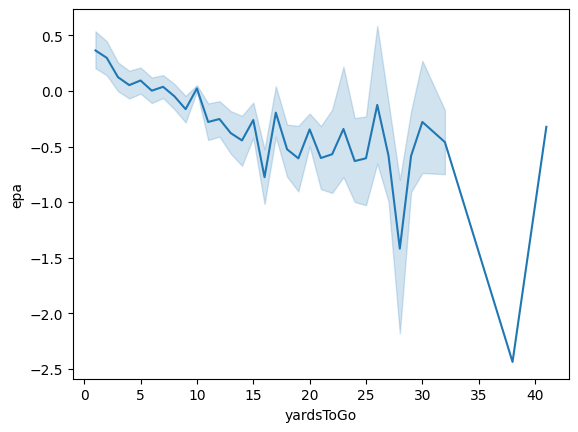

In [ ]:
sns.lineplot(x='yardsToGo', y='epa', data=plays)

This line plot models the relationship between ‘yardsToGo’ and ‘epa.’ We were interested in how ‘epa’ relates to other variables, so we created a simple line plot with only one of our potential predictor variables to help understand our response variable. In this plot, there appears to be a negative correlation between ‘yardsToGo’ and ‘epa.’


<Axes: xlabel='epa', ylabel='Count'>

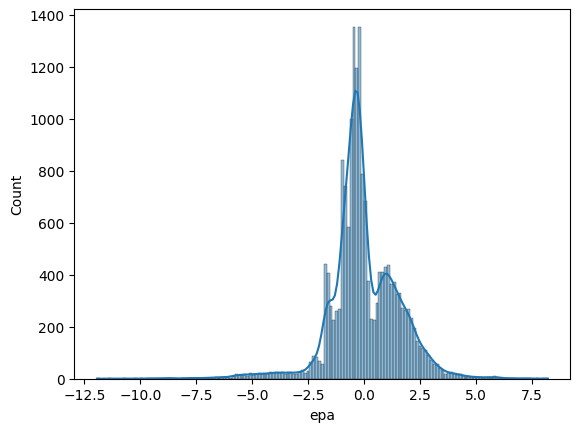

In [ ]:
sns.histplot(x='epa', data=plays, kde=True)

This histogram shows the distribution of EPA values across all plays in the dataset. The right side of the histogram has a shorter tail meaning that plays with high EPA are less frequent. There is a negative skew showing that plays with negative EPA occur frequently. Most of the plays hover around 0 EPA meaning that the plays have a neutral effect on scoring potential.


# **5. Model building**
Since we wanted to predict EPA values, we chose to use a regression model rather than a classification model. We chose to use a multiple linear regression because football is a complicated sport and many variables have an impact on each play, as our model ended up having 37 variables:



*   **yardsToGo, down_1, down_2, down_3, down_4, absoluteYardlineNumber:** We used these variable because, together, they extremely important in determining the likelihood of a plays success. For example, converting a 2nd & 1 on a team’s own 41 yard-line is going to result in a much lower EPA than converting a 3rd & 13 on an opponents 49 yard-line because the former is far more probable and a successful conversion has far less of an effect on a team’s win probability.

* **offensePlayResult:** This variable refers to the yards gained on a play, which would make sense to be highly correlated with EPA.

*   **defendersInTheBox, numberOfPassRushers:** These two variables are important for setting the context of a play. If there are many defenders in the box, a play-action pass is likely to be more successful because defenses are expecting run. The number of pass rushers is critical to know because whether or not a defense blitzes can change the likiehood of an explosive play and a sack. Coaches want to know how to beat blitzes and how to get defenses out of heavy boxes in rushing downs, so these variables are extremely useful.

*   **preSnapVisitorScore, preSnapHomeScore:** The score in the game greatly affects playcalling decisions and how teams operate.

*   **quarter_1, quarter_2, quarter_3, quarter_4, quarter_5, secondsRemaining:** Time remaining and quarter greatly influence an offense’s playcalling. For example, a team trailing by a touchdown in the fourth quarter with under two minutes remaining is likely to pass most, if not every, play. A defense therefore expects this and will play adequate personnel and coverage to match this expectation.

*   **O_RB, O_WR, O_TE, D_DB, D_LB, D_DL:** These variables track positions that vary in numbers based on the personnel and play call, so these are relevant to track. For example, defenses are likely to play more DBs when they expect offenses to pass and offenses are likely to play more WRs in obvious passing downs. Offenses also want to catch defenses by surprise and pass in personnel groupings that would lead defenses to expect run, so we figured these variables would be important to our model.
*   **typeDropback_DESIGNED_ROLLOUT_LEFT, typeDropback_DESIGNED_ROLLOUT_RIGHT, typeDropback_SCRAMBLE, typeDropback_SCRAMBLE_ROLLOUT_LEFT, typeDropback_SCRAMBLE_ROLLOUT_RIGHT, typeDropback_TRADITIONAL:** These variables track the type of dropback for the offenses’ QB. Generally, it is assumed that rolling a quarterback out of the pocket makes it easier for him than in a traditional dropback because it shortens the field and makes reads easier, so we wanted to see if this assumption holds in our model.


*   **offenseFormation_EMPTY, offenseFormation_I_FORM, offenseFormation_JUMBO, offenseFormation_PISTOL, offenseFormation_SHOTGUN, offenseFormation_SINGLEBACK, offenseFormation_WILDCAT:** These variables classify an offenses’ formation. Offenses are gravitating more towards the shotgun in the modern NFL, as many veteran QBs like to disect a defense from the shotgun. It’s generally thought of as a passing formation, so defenses are likely to combat this by expecting pass and playing coverage. Offenses are constantly looking for innovative ideas, so seeing what formations have the largest effect on EPA could be extremely useful for coaches.

In [ ]:
# define X (features), y (target variable)
X = plays.drop(columns=['epa'])
y = plays['epa']

We normalized all of our data because, with over 30 variables used, we have many different scales present within our data. We subtracted each data point by the column’s mean and divided it by the column’s standard deviation to get each variable on the same scale.


In [ ]:
X_whitened = X - X.mean()
X_whitened = X_whitened / X.std()

X_whitened.describe()

,yardsToGo,defendersInTheBox,numberOfPassRushers,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber,passResult,offensePlayResult,typeDropback_DESIGNED_ROLLOUT_LEFT,typeDropback_DESIGNED_ROLLOUT_RIGHT,...,quarter_3,quarter_4,quarter_5,O_RB,O_TE,O_WR,D_DL,D_LB,D_DB,secondsRemaining
count,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,...,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04,1.793500e+04
mean,-3.605207e-17,-3.656710e-16,-4.278707e-16,-3.644825e-17,-6.338826e-17,1.204377e-16,9.547856e-17,-5.546472e-18,1.980883e-17,1.822412e-17,...,1.103352e-16,6.814238e-17,-9.508238e-18,-2.646460e-16,5.625708e-17,7.963150e-17,-2.004654e-16,1.327192e-16,-5.181990e-16,-7.250032e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.998699e+00,-4.966338e+00,-4.982707e+00,-1.094957e+00,-1.177640e+00,-2.066045e+00,-1.243304e+00,-2.514083e+00,-8.805500e-02,-1.640410e-01,...,-5.338561e-01,-6.142178e-01,-9.517179e-02,-3.479960e+00,-2.363260e+00,-4.685584e+00,-3.681047e+00,-2.997435e+00,-6.063530e+00,-1.516086e+00
25%,-4.885071e-01,-3.721235e-02,-2.755777e-01,-7.883264e-01,-8.930050e-01,-8.398778e-01,-1.243304e+00,-6.312874e-01,-8.805500e-02,-1.640410e-01,...,-5.338561e-01,-6.142178e-01,-9.517179e-02,-2.182363e-01,-3.604688e-01,-1.258902e+00,-3.434660e-01,-7.452304e-01,-4.238470e-02,-9.362314e-01
50%,2.665886e-01,-3.721235e-02,-2.755777e-01,-1.750652e-01,-2.288561e-01,5.754638e-03,3.007106e-01,-2.349095e-01,-8.805500e-02,-1.640410e-01,...,-5.338561e-01,-6.142178e-01,-9.517179e-02,-2.182363e-01,-3.604688e-01,4.544389e-01,7.690611e-01,3.808718e-01,-4.238470e-02,-5.910909e-02
75%,2.665886e-01,9.486127e-01,9.012047e-01,6.426163e-01,7.199280e-01,8.513871e-01,3.007106e-01,3.596575e-01,-8.805500e-02,-1.640410e-01,...,-5.338561e-01,1.627996e+00,-9.517179e-02,-2.182363e-01,-3.604688e-01,4.544389e-01,7.690611e-01,3.808718e-01,-4.238470e-02,8.730627e-01
max,8.069244e+00,4.891913e+00,6.785117e+00,4.117763e+00,3.945794e+00,2.077554e+00,3.388740e+00,8.980878e+00,1.135590e+01,6.095695e+00,...,1.873059e+00,1.627996e+00,1.050673e+01,9.566934e+00,5.647903e+00,3.881121e+00,4.106643e+00,3.759178e+00,4.473475e+00,1.786885e+00


In [ ]:
# split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_whitened, y, test_size=0.2, random_state=16)

In [ ]:
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]

print(f"Number of samples in train set: {train_samples}")
print(f"Number of samples in test set: {test_samples}")

Number of samples in train set: 14348
Number of samples in test set: 3587


For our research question, we looked at many variables and how they affect Expected Points Added on passing plays. Looking at the results of our model, we can see a few observations. First of all, our model performed decently but was overall unspectacular. The training dataset had an $R^2$ value of .584 and the test data had an $R^2$ value of .575. This means that our model has some predictive value but has its share of flaws. Looking at the coefficient values, we can see that playResult is by far the most predictive of EPA, which matches what we’d expect, as the more yards a play results in, the more expected points a play should be worth. Looking at other variables that displayed larger magnitudes, we can see defensive personnel seem to have a major impact on EPA. All of D_DL, D_LB, and D_DB have coefficients of a high magnitude relative to the rest of the variables. This suggests that if defenses put unbalanced personnel groupings on the field, with a lot of DL for example, offenses tend to take advantage of it and generally have more successful EPA. 3rd and 4th downs tend to have a relatively high effect relative to other variables in this model, which makes sense considering how much a successful conversion could impact a team’s win probability. One trend we found surprising was that the different offensive formations tended to be near the bottom in terms of coefficient magnitude, suggesting a relatively small effect on EPA for passes.


In [ ]:
# fit linear regression model to predict epa
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)

coefs = pd.DataFrame(lr.coef_,
                     index=lr.feature_names_in_,
                     columns=['Coefficient vals'])

coefs = coefs.sort_values(by='Coefficient vals', ascending=False, key=abs)

train_R2 = round(lr.score(X_train, y_train), 3)
test_R2 = round(lr.score(X_test, y_test), 3)

print(f"Train R-squared score: {train_R2}")
print(f"Test R-squared score: {test_R2}")
coefs

Train R-squared score: 0.584
Test R-squared score: 0.575


,Coefficient vals
offensePlayResult,1.169477
D_DL,0.631079
D_LB,0.628016
D_DB,0.446312
passResult,-0.229165
yardsToGo,-0.198190
typeDropback_TRADITIONAL,0.098195
down_4,-0.059278
typeDropback_SCRAMBLE,0.059215
typeDropback_DESIGNED_ROLLOUT_RIGHT,0.056223


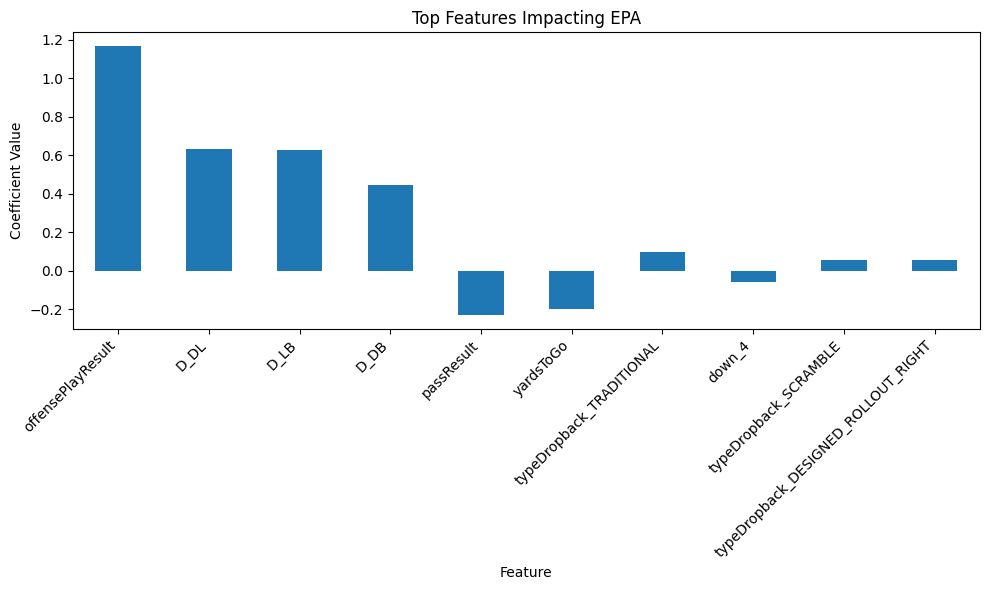

In [ ]:
# Feature Importance: Top Coefficients
top_features = coefs.head(10)  # Select top 10 coefficients
plt.figure(figsize=(10, 6))
top_features.iloc[:, 0].plot(kind='bar', title='Top Features Impacting EPA')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

An overall trend for our model suggests, due to the nature of the sport of football and how interconnected and complicated it is, that none of the variables are obviously much more significant in terms of predicting EPA. Except for playResult, which measures the result of the play in terms of yards, all of the other variables have coefficients that are very close to one another. playResult also differs from these other variables because it measures the result of the play, so it isn’t a variable that can be used to predict EPA pre-snap or during a play, like formation or dropback type can be used to.


Our dataset is so large that outliers do not have a large effect on our model, and our model isn’t likely to improve with more data. To improve our model, we could look for even more specific data, such as data regarding pre-snap motion or defensive coverage type. We could also try a different, more complex regression model.



This model could be used to help teams game plan and improve their passing schemes by examining what specific factors have the most weight on an individual play’s success. Some of the risks regarding the deployment of the model relate to the context needed to understand the impact of the model's results. For example, offenses pass out of formations like the shotgun far more often than out of jumbo, and when teams do pass out of run-heavy formations like jumbo, they can catch the defense off-guard with play-action because the defense is expecting a run. Even though our model suggests pass plays out of jumbo lead to more success than out of the shotgun, an offense can’t just implement a lot more of these passing concepts out of run-heavy formations because defenses will be less fooled by play-action if an offense continues to pass out of those formations. This model also classifies variables generally and doesn’t factor in player alignment or other important factors resulting in play success such as pre-snap motion. There are other formations and dropback types that aren’t included in our model, as we have the most common ones listed. If an offense gets extremely creative, it might not be properly accounted for in our model.


<Figure size 1000x600 with 0 Axes>

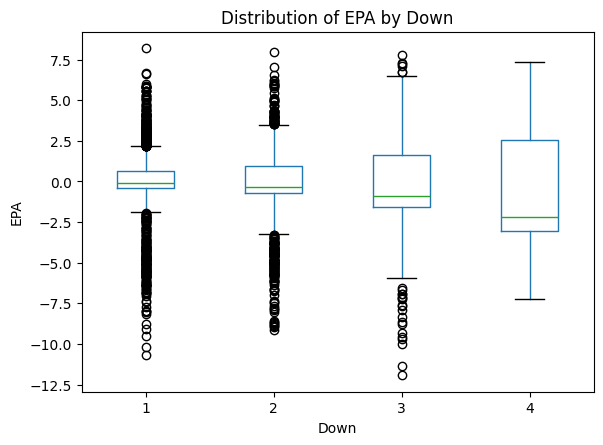

In [ ]:
# Distribution of EPA by Down
# Assuming 'down_2', 'down_3', 'down_4' exist as dummy variables
down_categories = ['down_1','down_2', 'down_3', 'down_4']
plays['down_category'] = plays[down_categories].idxmax(axis=1).str.split('_').str[1]

plt.figure(figsize=(10, 6))
plays.boxplot(column='epa', by='down_category', grid=False)
plt.title('Distribution of EPA by Down')
plt.suptitle('')
plt.ylabel('EPA')
plt.xlabel('Down')
plt.show()

We can see that far more outliers exist on 1st and 2nd downs rather than 3rd and 4th down, and the distribution for early downs are much more condensed. This is due to the impact of a successful 3rd or 4th down conversion on the outcome of the game. Late down plays are likely to have a higher magnitude of EPA because of how valuable extending and sustaining drives are. The best offenses in the NFL consistently are able to convert 3rd and 4th downs at high rates.

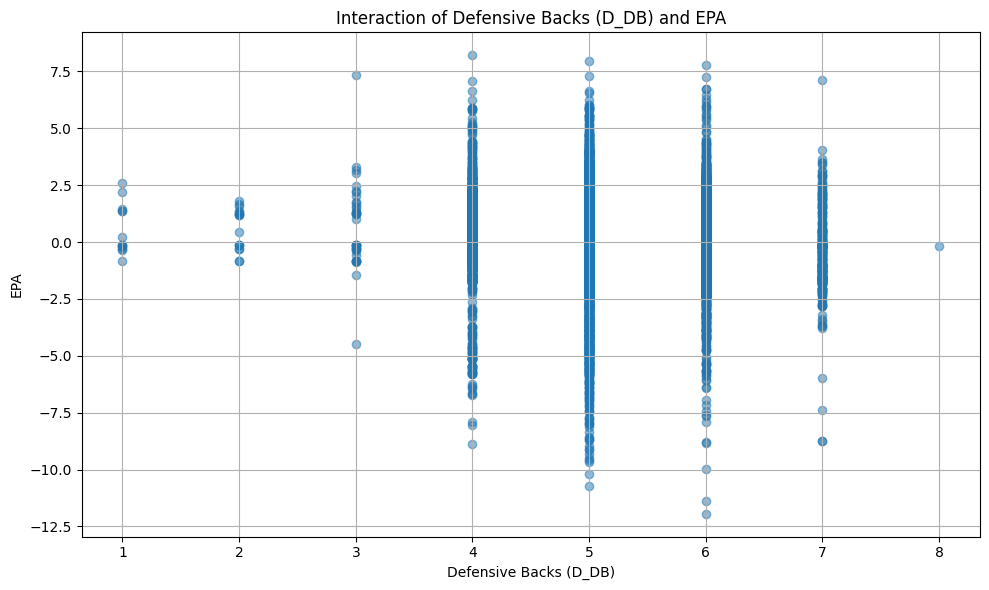

In [ ]:
# Interaction of Defensive Backs (D_DB) and EPA
plt.figure(figsize=(10, 6))
plt.scatter(plays['D_DB'], plays['epa'], alpha=0.5)
plt.title('Interaction of Defensive Backs (D_DB) and EPA')
plt.xlabel('Defensive Backs (D_DB)')
plt.ylabel('EPA')
plt.grid(True)
plt.tight_layout()
plt.show()

As discussed earlier, we can see how offenses have found success passing when defenses have unbalanced personnel on the field. Looking at when defenses are in quarter personnel (7 DBs) compared to dime (6 DBs), nickel (5 DBs), and base (4 DBs), we can see some noticeable differences in the EPA trends. Around half of the plays with quarter personnel go for postive EPA, compared to slightly less than half for dime and nickel.